In [ ]:
!pip3 install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 38.5 MB/s eta 0:00:00


In [ ]:
import os
import json
import subprocess
import traceback

import numpy as np

import mne
import scipy

import random

from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from os import walk
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from statsmodels.tsa.ar_model import AutoReg

In [ ]:
# Задача распознования по ЭЭГ
EEG_SETS = [
        ['EEG F7-A1', 'EEG F7-M1'],
        ['EEG F3-A1', 'EEG F3-M1'],
        ['EEG T3-A1', 'EEG T3-M1'],
        ['EEG C3-A1', 'EEG C3-M1'],
]

# Задача распознования по ЭЭГ + ЭМГ
EEG_and_EMG_SETS = [
        ['EEG F7-A1', 'EEG F7-M1'],
        ['EEG F3-A1', 'EEG F3-M1'],
        ['EEG T3-A1', 'EEG T3-M1'],
        ['EEG C3-A1', 'EEG C3-M1'],
        ['EEG Oz-A2','EEG Oz-M2'],
        ['EEG Fpz-A2','EEG Fpz-M2']
]

# используемые каналы
TARGET_CHANNEL_SETS = EEG_SETS

# кол-во каналов для подачи в модель
TARGET_CHANNELS = 4
SECTOR_LENGTH = 600

# Phonemes are enumerated in range 1, 2, 3, 4, 5, 6, 7
MIN_PHONEME_ID = 1 # для смещения фонем к 0
PHONEME_COUNT  = 7 # Бинарная - 1, Многоклассовая - 7

## Открываем данные

In [ ]:
myography_prosebaya_path = '/content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya'
myography_vsluh_path = '/content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_vsluh'

myography_prosebaya_filenames = sorted(next(walk(myography_prosebaya_path), (None, None, []))[2])
myography_vsluh_filenames = sorted(next(walk(myography_vsluh_path), (None, None, []))[2])

edf_prosebaya = []
for filename in myography_prosebaya_filenames:
    file_with_path = f'{myography_prosebaya_path}/{filename}'
    edf = mne.io.read_raw_edf(file_with_path)
    edf_prosebaya.append(edf)

edf_vsluh = []
for filename in myography_vsluh_filenames:
    file_with_path = f'{myography_vsluh_path}/{filename}'
    edf = mne.io.read_raw_edf(file_with_path)
    edf_vsluh.append(edf)

Extracting EDF parameters from /content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/AbrosimovaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/AlyaksinaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/MorozovaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/NoginaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab_Not

## Выделение каналов, сегментация

In [ ]:
def extract_strict_sectors(edf, sector_length = 600 ):
	"""
	Extract sectors of the given length using labels.
	Sample usage is extracting sectors of length 600 ms (1024Hz).

	Returns segments[begin,end] and labels

		** 1n восприятие / n проговаривание
	"""
	sectors = []
	labels = []

	number_of_current_phoneme = None
	counter = 0
	silent_speach = False

	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]

	for index, (timestamp, value) in enumerate(zip(X, Y)):
		counter-=1
		if value > 0:
			value = int(value)

			# segment begin of silent speach
			if value // 10 == 0:
				counter = sector_length + 100
				number_of_current_phoneme = value % 10
				silent_speach = True
			else:
				silent_speach = False # another label

		if silent_speach and counter == 0:
			sectors.append((index - sector_length, index))
			labels.append(number_of_current_phoneme)

	return sectors, labels

In [ ]:
def subselect_channels(edf, target_channels = TARGET_CHANNEL_SETS ):
    all_channels = edf.ch_names
    channels = []

    for target_channel in target_channels:
        for channel_name_optiont in target_channel:
            if channel_name_optiont in all_channels:
                data_channel = edf[channel_name_optiont]
                Y_channel = list(data_channel[0][0]) # Значения сигнала
                X_channel = data_channel[1] # Время
                channels.append(Y_channel)

    if len(channels) != len(target_channels):
         raise RuntimeError(f'Not all channels found')
    else:
        return channels

In [ ]:
def split_sectors(channels_data, sectors):
    '''
    Выделяем сегменты из данных по каналам, используя сектора
    '''
    splitted  = [[None] * len(sectors) for i in range(len(channels_data))]

    for i_sector, sector in enumerate(sectors):
        a, b  = sector

        for i_channel, channel_data in enumerate(channels_data):
            splitted[i_channel][i_sector] = channel_data[a:b]

    return splitted


In [ ]:
def get_person_segments(efd, target_channels = TARGET_CHANNEL_SETS):
    '''
    Получаем из данных efd испытуемого сегменты с метками по целевым каналам (target_channels)
    '''
    channels_data = subselect_channels(efd, target_channels)
    sectors, labels = extract_strict_sectors(efd)

    segments = [[None] * len(sectors) for i in range(len(channels_data))]

    for i_sector, sector in enumerate(sectors):
        a, b  = sector

        for i_channel, channel_data in enumerate(channels_data):
            segments[i_channel][i_sector] = channel_data[a:b]

    return segments, labels


In [ ]:
def normalize_labels(labels, min_phoneme_id = MIN_PHONEME_ID):
    return [p - min_phoneme_id for p in labels]

In [ ]:
# для бинарной классификации
def get_two_segments_by_labels(segments, labels, label0 = 1, label1 = 2):
    segments_by_label0 = [[] for i in range(len(segments))]
    segments_by_label1 = [[] for i in range(len(segments))]

    for i_channel, channel in enumerate(segments):
        for i_segment, (segment, l) in enumerate(zip(channel, labels)):
            if l == label0:
                segments_by_label0[i_channel].append(segments[i_channel][i_segment])

            if l == label1:
                segments_by_label1[i_channel].append(segments[i_channel][i_segment])

    return (segments_by_label0, [0]*len(segments_by_label0[0])), (segments_by_label1, [1]*len(segments_by_label1[0]))

 # SVM | статистики

## среднее, std

фильтр Калмана попробовать

Подсчитаем для всех испытуемых:


In [ ]:
data = []
all_labels = []
for i_edf_person, edf_person in enumerate(edf_prosebaya):

    segments, labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
    labels = normalize_labels(labels, MIN_PHONEME_ID )
    all_labels.append(labels)

    person_data = []
    for i_segment in range(len(segments[0])):
        segment_data = []
        for i_channel in range(len(segments)):

            segment = segments[i_channel][i_segment]
            window = 200
            for i in range(0, len(segment), window ):

                mean = np.mean(segment[i:i+window])
                std = np.std(segment)
                var = np.var(segment)
                segment_data.append(std)
                segment_data.append(mean)
                segment_data.append(var)
        person_data.append(segment_data)
    data.append(person_data)

In [ ]:
res = [[],[],[],[],[],[]]
for i in range(5):
    for i_person, person_data in enumerate(data):
        labels = all_labels[i_person]

       # print(f'{i_person}')
        X = person_data
        Y = list(range(0,7))

        X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2, stratify=labels)

        clf = SVC(decision_function_shape='ovo')
        clf.fit(X_train, y_train)
        dec = clf.decision_function(X_train)
        dec.shape[1] # 7 classes: 7*6/2 = 21

        clf.decision_function_shape = "ovr"
        dec = clf.decision_function(X_train)
        dec.shape[1] # 7 classes

        predicted = clf.predict(X_test)
        match_count = (predicted == y_test).sum().item()
       # print(f'MATCH = {round(match_count/len(y_test),2)*100}%' )
        res[i_person].append(int(round(match_count/len(y_test),2)*100))

In [ ]:
for i_person, res_match in enumerate(res):
    print(f"person {i_person} : {res_match}" )

 ## PSD ( Power Spectral Density )

In [ ]:
edf_person = edf_prosebaya[0]

segments, labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
labels = normalize_labels(labels, MIN_PHONEME_ID )

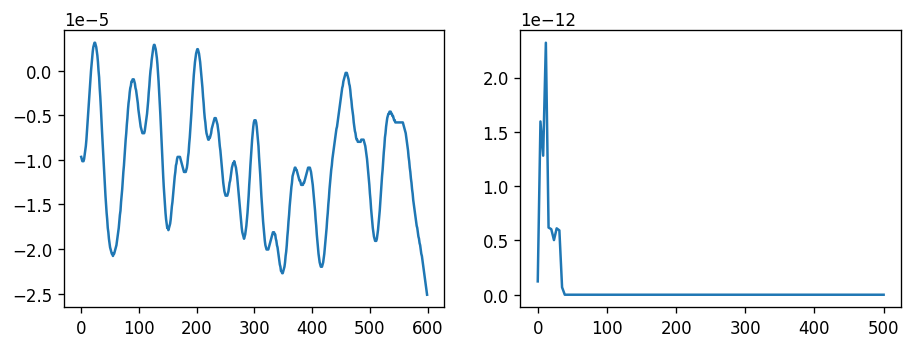

In [ ]:
segment = segments[0][1]

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

welch_segment = scipy.signal.welch(segment, fs = 1000 )

fig, axes = plt.subplots(1, 2)
axes[0].plot(segment)
axes[1].plot(welch_segment[0], welch_segment[1])

plt.show()

relative power in specific frequency bands: alpha (8-13 Hz), beta (13-30 Hz) and gamma (30-100 Hz).

In [ ]:
alpha = welch_segment[1][8:14]
beta = welch_segment[1][13:31]
gamma = welch_segment[1][30:101]

sum(alpha), sum(beta), sum(gamma)

(6.615041001603177e-13, 1.821278788584373e-16, 7.28182278852302e-16)

In [ ]:
data = []
all_labels = []
for i_edf_person, edf_person in enumerate(edf_prosebaya):

    segments, labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
    labels = normalize_labels(labels, MIN_PHONEME_ID )
    all_labels.append(labels)

    person_data = []
    for i_segment in range(len(segments[0])):
        segment_data = []
        for i_channel in range(len(segments)):

            segment = segments[i_channel][i_segment]


            welch_segment = scipy.signal.welch(segment, fs = 1000 )

            alpha = welch_segment[1][8:14]
            beta = welch_segment[1][13:31]
            gamma = welch_segment[1][30:101]

            segment_data.append(sum(alpha))
            segment_data.append(sum(beta))
            segment_data.append(sum(gamma))

            window = 200
            for i in range(0, len(segment), window ):

                mean = np.mean(segment[i:i+window])
                std = np.std(segment)
                var = np.var(segment)

                segment_data.append(std)
                segment_data.append(mean)
                segment_data.append(var)

        person_data.append(segment_data)
    data.append(person_data)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
res = [[],[],[],[],[],[]]
for i in range(10):
    for i_person, person_data in enumerate(data):
        labels = all_labels[i_person]

        X = person_data

        X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.25, stratify=labels)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf = SVC(decision_function_shape='ovo')
        clf.fit(X_train, y_train)
        dec = clf.decision_function(X_train)
        dec.shape[1] # 7 classes: 7*6/2 = 21

        clf.decision_function_shape = "ovr"
        dec = clf.decision_function(X_train)
        dec.shape[1] # 7 classes

        predicted = clf.predict(X_test)
        match_count = (predicted == y_test).sum().item()
       # print(f'MATCH = {round(match_count/len(y_test),2)*100}%' )
        res[i_person].append(int(round(match_count/len(y_test),2)*100))
for i_person, res_match in enumerate(res):
    print(f"person {i_person} : {res_match}" )

150

person 0 : [14, 17, 9, 28, 14, 14, 14, 20, 20, 23]

person 1 : [14, 17, 19, 19, 25, 19, 22, 19, 17, 11]

person 2 : [16, 20, 8, 12, 24, 16, 8, 12, 16, 8]

person 3 : [13, 17, 9, 9, 17, 17, 22, 17, 17, 22]

person 4 : [26, 23, 23, 19, 16, 26, 19, 13, 16, 35]

person 5 : [22, 14, 11, 14, 11, 24, 16, 3, 19, 11]

## Discrete wavelet transform (DWT) with Filter bank


In [ ]:
!pip install scaleogram

In [ ]:
import pywt
import scaleogram as scg

In [ ]:
print(pywt.wavelist(kind='discrete'))

In [ ]:
segment = segments[0][3]

In [ ]:
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(segment)
plt.show()

data = segment
waveletname = 'db3'

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

### Make CVS file with DWT

In [ ]:
import csv

In [ ]:
header_6 = ['person_id', 'label_phoneme', 'sector_id', 'channel',
          'DTW_1_AR1', 'DTW_1_AR2', 'DTW_1_AR3', 'DTW_1_AR4', 'DTW_1_AR5', 'DTW_1_AR6', 'DTW_1_MAD', 'DTW_1_STD',
          'DTW_2_AR1', 'DTW_2_AR2', 'DTW_2_AR3', 'DTW_2_AR4', 'DTW_2_AR5', 'DTW_2_AR6', 'DTW_2_MAD', 'DTW_2_STD',
          'DTW_3_AR1', 'DTW_3_AR2', 'DTW_3_AR3', 'DTW_3_AR4', 'DTW_3_AR5', 'DTW_3_AR6', 'DTW_3_MAD', 'DTW_3_STD',
          'DTW_4_AR1', 'DTW_4_AR2', 'DTW_4_AR3', 'DTW_4_AR4', 'DTW_4_AR5', 'DTW_4_AR6', 'DTW_4_MAD', 'DTW_4_STD',
          ]
header_4 = ['person_id', 'label_phoneme', 'sector_id', 'channel',
          'DTW_1_AR1', 'DTW_1_AR2', 'DTW_1_AR3', 'DTW_1_AR4',  'DTW_1_MAD', 'DTW_1_STD',
          'DTW_2_AR1', 'DTW_2_AR2', 'DTW_2_AR3', 'DTW_2_AR4',  'DTW_2_MAD', 'DTW_2_STD',
          'DTW_3_AR1', 'DTW_3_AR2', 'DTW_3_AR3', 'DTW_3_AR4',  'DTW_3_MAD', 'DTW_3_STD',
          'DTW_4_AR1', 'DTW_4_AR2', 'DTW_4_AR3', 'DTW_4_AR4',  'DTW_4_MAD', 'DTW_4_STD',
          ]
header_8 = ['person_id', 'label_phoneme', 'sector_id', 'channel',
          'DTW_1_AR1', 'DTW_1_AR2', 'DTW_1_AR3', 'DTW_1_AR4', 'DTW_1_AR5', 'DTW_1_AR6', 'DTW_1_AR7', 'DTW_1_AR8', 'DTW_1_MAD', 'DTW_1_STD',
          'DTW_2_AR1', 'DTW_2_AR2', 'DTW_2_AR3', 'DTW_2_AR4', 'DTW_2_AR5', 'DTW_2_AR6', 'DTW_2_AR7', 'DTW_2_AR8', 'DTW_2_MAD', 'DTW_2_STD',
          'DTW_3_AR1', 'DTW_3_AR2', 'DTW_3_AR3', 'DTW_3_AR4', 'DTW_3_AR5', 'DTW_3_AR6', 'DTW_3_AR7', 'DTW_3_AR8', 'DTW_3_MAD', 'DTW_3_STD',
          'DTW_4_AR1', 'DTW_4_AR2', 'DTW_4_AR3', 'DTW_4_AR4', 'DTW_4_AR5', 'DTW_4_AR6', 'DTW_4_AR7', 'DTW_4_AR8', 'DTW_4_MAD', 'DTW_4_STD',
          ]

In [ ]:
rows_data = []

for i_edf_person, edf_person in enumerate(edf_prosebaya):

    segments, labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
    labels = normalize_labels(labels, MIN_PHONEME_ID )

    for i_segment in range(len(segments[0])):
        for i_channel in range(len(segments)):

            features = []

            segment = segments[i_channel][i_segment]
            waveletname = 'db3'

            data = segment

            for i_level in range(4):

                (data, coeff_d) = pywt.dwt(data, waveletname)
                AutoRegRes = AutoReg(data, 3).fit()
                features += list(AutoRegRes.params)

                MAD = stats.median_abs_deviation(data)
                features.append(MAD)

                std = np.std(data)
                features.append(std)

            row = [i_edf_person, labels[i_segment],i_segment, TARGET_CHANNEL_SETS[i_channel][0]]
            row += features

            rows_data.append(row)

In [ ]:
with open("phoneme_EEG_DTW_4AR.csv", 'w', newline='') as file:
    csvwriter = csv.writer(file, quoting=csv.QUOTE_NONNUMERIC)
    csvwriter.writerow(header_4)
    csvwriter.writerows(rows_data)

In [ ]:
len(rows_data[0])

44

In [ ]:
pywt.wavelist()

In [ ]:
scales = np.arange(1, 500)
coefficients, frequencies = pywt.cwt(segment, scales=scales, wavelet='gaus1')

In [ ]:
plt.figure(figsize=(20, 7))
fig, axs = plt.subplots(2, 3)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 7

coefficients0, frequencies = pywt.cwt(segment, scales=np.arange(1, 500) , wavelet='gaus1')
coefficients1, frequencies = pywt.cwt(segment, scales=np.arange(1, 250) , wavelet='gaus1')
coefficients2, frequencies = pywt.cwt(segment, scales=np.arange(250, 500) , wavelet='gaus1')
coefficients3, frequencies = pywt.cwt(segment, scales=np.arange(1, 125) , wavelet='gaus1')
coefficients4, frequencies = pywt.cwt(segment, scales=np.arange(125, 250) , wavelet='gaus1')
coefficients5, frequencies = pywt.cwt(segment, scales=np.arange(1, 62.5) , wavelet='gaus1')
coefficients6, frequencies = pywt.cwt(segment, scales=np.arange(62.5, 125 ) , wavelet='gaus1')


axs[0][0].pcolormesh(np.abs(coefficients1), cmap='viridis', shading='gouraud')
axs[0][0].set_title('Frequencies [1, 250]')
axs[0][1].pcolormesh(np.abs(coefficients2), cmap='viridis', shading='gouraud')
axs[0][1].set_title('Frequencies [250, 500]')
axs[0][2].pcolormesh(np.abs(coefficients3), cmap='viridis', shading='gouraud')
axs[0][2].set_title('Frequencies [1, 125]')
axs[1][0].pcolormesh(np.abs(coefficients4), cmap='viridis', shading='gouraud')
axs[1][0].set_title('Frequencies [125, 250]')
axs[1][1].pcolormesh(np.abs(coefficients5), cmap='viridis', shading='gouraud')
axs[1][1].set_title('Frequencies [1, 62.5]')
axs[1][2].pcolormesh(np.abs(coefficients6), cmap='viridis', shading='gouraud')
axs[1][2].set_title('Frequencies [62.5, 125]')

plt.show()

In [ ]:
plt.figure(figsize=(20, 7))
fig, axs = plt.subplots(1, 1)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 7

sector_length = 600
source_freq = 1000
max_morlet_freq = 30
w = 6.0

t, dt = np.linspace(0, sector_length / source_freq, sector_length, retstep=True)
freq = np.linspace(1, max_morlet_freq, max_morlet_freq)
fs = 1 / dt
widths = w * fs / (2 * freq * np.pi)

print(f'widths -  {widths}')
coefficients0 = signal.cwt(segment, signal.morlet2 , widths, w = w)


axs.pcolormesh(np.abs(coefficients0), cmap='viridis', shading='gouraud')

In [ ]:
len(widths)

In [ ]:
stats.median_abs_deviation(segment)

In [ ]:
AutoRegRes = AutoReg(segment, 5).fit()

In [ ]:
AutoRegRes.params

In [ ]:
a = []
a+=list(AutoRegRes.params)
a.append(3)

In [ ]:
a

# AutoARIMA

Смотрим, что выдала нам для всех рядов

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm

In [ ]:
# очень долго считалось, поэтому остановила
params = []

for channel in segments:
    for timeserie in channel:
        arima_model = pm.auto_arima(timeserie)
        params.append(arima_model.order)

In [ ]:
len(params)

485

In [ ]:
exogenous_coefficients = [i[0] for i in params]
AR_coefficients = [i[1] for i in params]
MA_coefficients = [i[2] for i in params]

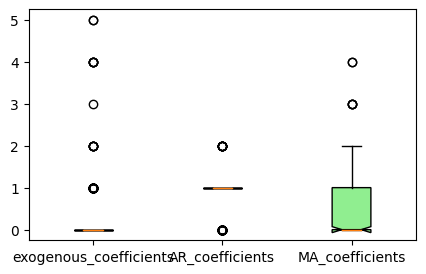

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
names = ["exogenous_coefficients", "AR_coefficients", "MA_coefficients"]

bplot = ax.boxplot([exogenous_coefficients, AR_coefficients, MA_coefficients],  vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     notch=True,
                     labels=names)
colors = ['pink', 'lightblue', 'lightgreen']

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

# SVM | ARIMA (1,1,0)

In [ ]:
import statsmodels.api as sm

p = порядок члена AR

q = порядок члена MA

d = количество разностей, необходимых для того, чтобы временной ряд стал стационарным.

In [ ]:
efd_person = edf_prosebaya[0]

segments, labels = get_person_segments(efd_person, target_channels = TARGET_CHANNEL_SETS )
labels = normalize_labels(labels)

In [ ]:
len(segments), len(segments[0])

(4, 173)

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
p, d, q = 1, 1, 0

person_data = []
for i_segment in range(len(segments[0])):
    segment_data = []
    for i_channel in range(len(segments)):
        segment = segments[i_channel][i_segment]
        try:
            res = sm.tsa.arima.ARIMA(segment, order = (p, d, q)).fit()
            segment_data.append(res.params)
        except:
            print("ошибка")
    person_data.append(segment_data)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/statsmodels/tools/numdiff.py:251: RuntimeWarning: overflow encountered in divide
  partials = [f(x+ih, *args, **kwargs).imag / epsilon[i]


ошибка


In [ ]:
print("Кол-во сегментов  - ", len(person_data))
print("Кол-во меток - ", len(labels))
print("Кол-во признаков сегмента  - ", len(person_data[0]))

Кол-во сегментов  -  173
Кол-во меток -  173
Кол-во признаков сегмента  -  4


In [ ]:
person_data_ = []
labels_ = []
for segment, label in zip(person_data, labels):
    s = []
    for timeseries in segment:
        for i in timeseries:
                s.append(i)

    if len(s) == 8:
        person_data_.append(s)
        labels_.append(label)

In [ ]:
X = person_data_
Y = list(range(0,7))

X_train, X_test, y_train, y_test = train_test_split(X, labels_, test_size = 0.2)

In [ ]:
clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)
dec = clf.decision_function(X_train)
dec.shape[1] # 7 classes: 7*6/2 = 21

clf.decision_function_shape = "ovr"
dec = clf.decision_function(X_train)
dec.shape[1] # 7 classes

7

In [ ]:
predicted = clf.predict(X_test)

match_count = (predicted == y_test).sum().item()
print(f'MATCH = {round(match_count/len(y_test),2)*100}%' )

MATCH = 20.0%


Для всех:

In [ ]:
data = []
all_labels = []
for i_edf_person, edf_person in enumerate(edf_prosebaya):

    segments, labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
    labels = normalize_labels(labels, MIN_PHONEME_ID )
    all_labels.append(labels)

    person_data = []
    for i_segment in range(len(segments[0])):
        segment_data = []
        for i_channel in range(len(segments)):
            segment = segments[i_channel][i_segment]
            try:
                res = sm.tsa.arima.ARIMA(segment, order = (p, d, q)).fit()
                segment_data.append(res.params)
            except:
                print("ошибка")
        person_data.append(segment_data)

    data.append(person_data)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/statsmodels/tools/numdiff.py:251: RuntimeWarning: overflow encountered in divide
  partials = [f(x+ih, *args, **kwargs).imag / epsilon[i]


ошибка
ошибка
ошибка
ошибка
ошибка
ошибка
ошибка


In [ ]:
res = [[],[],[],[],[],[]]
for i in range(5):
    for i_person, person_data in enumerate(data):
        labels = all_labels[i_person]

        person_data_ = []
        labels_ = []
        for segment, label in zip(person_data, labels):
            s = []
            for timeseries in segment:
                for i in timeseries:
                        s.append(i)

            if len(s) == 8:
                person_data_.append(s)
                labels_.append(label)

       # print(f'{i_person}')
        X = person_data_
        Y = list(range(0,7))

        X_train, X_test, y_train, y_test = train_test_split(X, labels_, test_size = 0.2)

        clf = SVC(decision_function_shape='ovo')
        clf.fit(X_train, y_train)
        dec = clf.decision_function(X_train)
        dec.shape[1] # 7 classes: 7*6/2 = 21

        clf.decision_function_shape = "ovr"
        dec = clf.decision_function(X_train)
        dec.shape[1] # 7 classes

        predicted = clf.predict(X_test)
        match_count = (predicted == y_test).sum().item()
       # print(f'MATCH = {round(match_count/len(y_test),2)*100}%' )
        res[i_person].append(int(round(match_count/len(y_test),2)*100))

In [ ]:
for i_person, res_match in enumerate(res):
    print(f"person {i_person} : {res_match}" )

person 0 : [14, 11, 14, 14, 14]
person 1 : [3, 3, 14, 9, 6]
person 2 : [12, 12, 12, 16, 16]
person 3 : [9, 4, 9, 9, 4]
person 4 : [16, 3, 13, 13, 16]
person 5 : [8, 5, 5, 8, 11]


# SVM | ARIMA ( 10, 10, 3 )

Для всех:

In [ ]:
data = []
all_labels = []

p, d, q = 10, 10, 3

for i_edf_person, edf_person in enumerate(edf_prosebaya):

    segments, labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
    labels = normalize_labels(labels, MIN_PHONEME_ID )
    all_labels.append(labels)

    person_data = []
    for i_segment in range(len(segments[0])):
        segment_data = []
        for i_channel in range(len(segments)):
            segment = segments[i_channel][i_segment]
            try:
                res = sm.tsa.arima.ARIMA(segment, order = (p, d, q)).fit()
                segment_data.append(res.params)
            except Exception as inst:
                print(f"ошибка {inst}")
        person_data.append(segment_data)

    data.append(person_data)

In [ ]:
res = [[],[],[],[],[],[]]
for i in range(5):
    for i_person, person_data in enumerate(data):
        labels = all_labels[i_person]

        person_data_ = []
        labels_ = []
        for segment, label in zip(person_data, labels):
            s = []
            for timeseries in segment:
                for i in timeseries:
                        s.append(i)

            if len(s) == 56:
                person_data_.append(s)
                labels_.append(label)

       # print(f'{i_person}')
        X = person_data_
        Y = list(range(0,7))

        X_train, X_test, y_train, y_test = train_test_split(X, labels_, test_size = 0.2)

        clf = SVC(decision_function_shape='ovo')
        clf.fit(X_train, y_train)
        dec = clf.decision_function(X_train)
        dec.shape[1] # 7 classes: 7*6/2 = 21

        clf.decision_function_shape = "ovr"
        dec = clf.decision_function(X_train)
        dec.shape[1] # 7 classes

        predicted = clf.predict(X_test)
        match_count = (predicted == y_test).sum().item()
       # print(f'MATCH = {round(match_count/len(y_test),2)*100}%' )
        res[i_person].append(int(round(match_count/len(y_test),2)*100))

In [ ]:
for i_person, res_match in enumerate(res):
    print(f"person {i_person} : {res_match}" )

person 0 : [14, 11, 14, 14, 14]
person 1 : [3, 3, 14, 9, 6]
person 2 : [12, 12, 12, 16, 16]
person 3 : [9, 4, 9, 9, 4]
person 4 : [16, 3, 13, 13, 16]
person 5 : [8, 5, 5, 8, 11]


# MODEL

In [ ]:
import sklearn
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split

In [ ]:
X = params_for_person[0]
Y = list(range(0,7))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2)

In [ ]:
clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)
dec = clf.decision_function(X_train)
dec.shape[1] # 7 classes: 7*6/2 = 21

clf.decision_function_shape = "ovr"
dec = clf.decision_function(X_train)
dec.shape[1] # 7 classes

7

In [ ]:
predicted = clf.predict(X_test)
match_count = (predicted == y_test).sum().item()
print(f'MATCH = {round(match_count/len(y_test),2)*100}%' )

MATCH = 6.0%


In [ ]:
lin_clf = LinearSVC(dual="auto")
lin_clf.fit(X_train, y_train)
dec = lin_clf.decision_function([[1]])
dec.shape[1]

In [ ]:
predicted = lin_clf.predict(test_x)
match_count = (predicted == test_y).sum().item()